In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical,Sequence
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

In [4]:
import os
import zipfile

# 압축 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/화재-20241217T210030Z-001.zip'  # 실제 경로로 수정하세요.
extract_path = '/content/stft_data_fire'  # 압축을 해제할 경로

# 압축 해제할 폴더 생성
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Files extracted to: {extract_path}")


Files extracted to: /content/stft_data_fire


In [5]:
# 압축 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/대피아닌 것-20241217T210027Z-001.zip'  # 실제 경로로 수정하세요.
extract_path = '/content/stft_data_fire'  # 압축을 해제할 경로

# 압축 해제할 폴더 생성
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Files extracted to: {extract_path}")


Files extracted to: /content/stft_data_fire


In [6]:
# 데이터 경로 설정
data_path = '/content/stft_data_fire'
categories = ['화재', '대피아닌 것']  # 클래스 이름
img_height, img_width = 128, 128  # 이미지 리사이징 크기 (임의로 설정)

In [7]:
# 데이터 불러오기 및 전처리
def load_data(data_path, categories):
    X = []  # 입력 데이터 (STFT)
    y = []  # 라벨 (0: 대피아닌 것, 1: 화재)

    for idx, category in enumerate(categories):
        folder_path = os.path.join(data_path, category)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith('.npy'):
                stft_data = np.load(file_path)  # STFT 데이터 로드

                # 채널 차원 추가 (2D -> 3D: (Height, Width) -> (Height, Width, 1))
                stft_data = stft_data[..., np.newaxis]

                # 데이터 크기 조정 (128x128로 리사이즈)
                resized_data = tf.image.resize(stft_data, [img_height, img_width]).numpy()

                X.append(resized_data)
                y.append(idx)

    X = np.array(X)
    y = np.array(y)
    return X, y
# 데이터 불러오기
X, y = load_data(data_path, categories)

# 데이터 분할 (Train, Validation, Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)  # 90% Train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  # 15% Validation, 15% Test

In [8]:
len(y)#337
sum(y)#148
len(y)-sum(y)#189

189

In [9]:
X_train.shape, X_test.shape, X_val.shape

((272, 128, 128, 1), (34, 128, 128, 1), (31, 128, 128, 1))

In [10]:
# 학습 데이터 증강 함수
def augment_data(image):
    augmented_images = []

    # 좌우 반전
    flipped = tf.image.flip_left_right(image)
    augmented_images.append(flipped.numpy())

    # 밝기 조절
    bright = tf.image.adjust_brightness(image, delta=0.1)
    augmented_images.append(bright.numpy())

    # 노이즈 추가
    noise = image + 0.05 * np.random.randn(*image.shape)
    noise = np.clip(noise, 0.0, 1.0)
    augmented_images.append(noise)

    return augmented_images

# 학습 데이터 증강
augmented_X = []
augmented_y = []

for i in range(len(X_train)):
    augmented_X.append(X_train[i])
    augmented_y.append(y_train[i])

    # 증강된 이미지 추가
    for augmented in augment_data(X_train[i]):
        augmented_X.append(augmented)
        augmented_y.append(y_train[i])

# numpy 배열로 변환
X_train_aug = np.array(augmented_X)
y_train_aug = np.array(augmented_y)

print(f"Augmented training data shape: {X_train_aug.shape}")

Augmented training data shape: (1088, 128, 128, 1)


In [11]:
print(f"Training data shape: {X_train_aug.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1088, 128, 128, 1)
Validation data shape: (31, 128, 128, 1)
Test data shape: (34, 128, 128, 1)


In [12]:
# 라벨 원-핫 인코딩
y_train_aug = to_categorical(y_train_aug, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [13]:
y_train_aug.shape

(1088, 2)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


# CNN 모델 생성
model = Sequential([
    # 첫 번째 컨볼루션 블록
    Conv2D(32, (3, 3), activation='swish', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),  # 배치 정규화 추가
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # 드롭아웃 추가

    # 두 번째 컨볼루션 블록
    Conv2D(64, (4, 4), activation='swish'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 세 번째 컨볼루션 블록
    Conv2D(64, (5, 5), activation='swish'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 네 번째 컨볼루션 블록
    Conv2D(64, (4, 4), activation='swish'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 다섯 번째 컨볼루션 블록
    Conv2D(32, (3, 3), activation='swish'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 완전 연결 계층
    Flatten(),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),  # 기존 0.3 유지
    Dense(2, activation='softmax')  # 최종 출력층
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [36]:
from tensorflow.keras.callbacks import EarlyStopping
# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 데이터의 손실을 기준으로 조기 종료
    patience=5,          # 개선되지 않는 Epoch 수 (5회 이상 멈춤)
    restore_best_weights=True,  # 가장 좋은 모델의 가중치로 복원
    verbose=1            # 종료 시 메시지 출력
)

In [37]:
# 모델 학습
history = model.fit(
    X_train_aug, y_train_aug,
    epochs=50,                     # 최대 Epoch 수
    batch_size=32,
    validation_data=(X_val, y_val),  # 검증 데이터
    callbacks=[early_stopping]     # EarlyStopping 콜백 추가
)

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.5239 - loss: 0.9122 - val_accuracy: 0.5806 - val_loss: 1.5470
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5735 - loss: 0.7391 - val_accuracy: 0.5806 - val_loss: 0.8656
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6500 - loss: 0.6561 - val_accuracy: 0.5806 - val_loss: 1.0093
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6707 - loss: 0.6199 - val_accuracy: 0.6129 - val_loss: 0.6628
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6673 - loss: 0.5888 - val_accuracy: 0.8065 - val_loss: 0.5527
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7150 - loss: 0.5269 - val_accuracy: 0.8710 - val_loss: 0.5300
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7338 - loss: 0.4894 - val_accuracy: 0.7097 - val_loss: 0.5759
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7481 - loss: 0.4828 - val_accuracy: 0.8710 - 

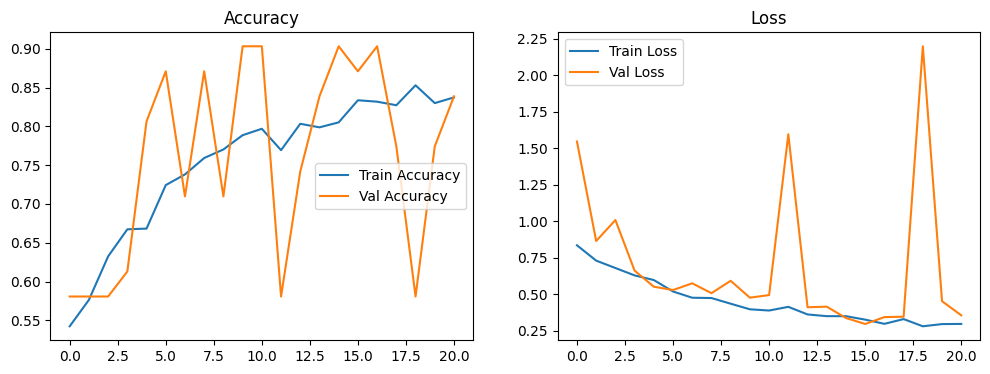

In [38]:
import matplotlib.pyplot as plt

# 학습 정확도 및 손실 시각화
plt.figure(figsize=(12, 4))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [39]:
model.summary(

)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 60, 60, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 26, 26, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 10, 10, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 3, 3, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 32)            │              

 Total params: 675,560 (2.58 MB)

 Trainable params: 224,930 (878.63 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 449,862 (1.72 MB)

Loaded Spectrogram Shape: (1025, 469)


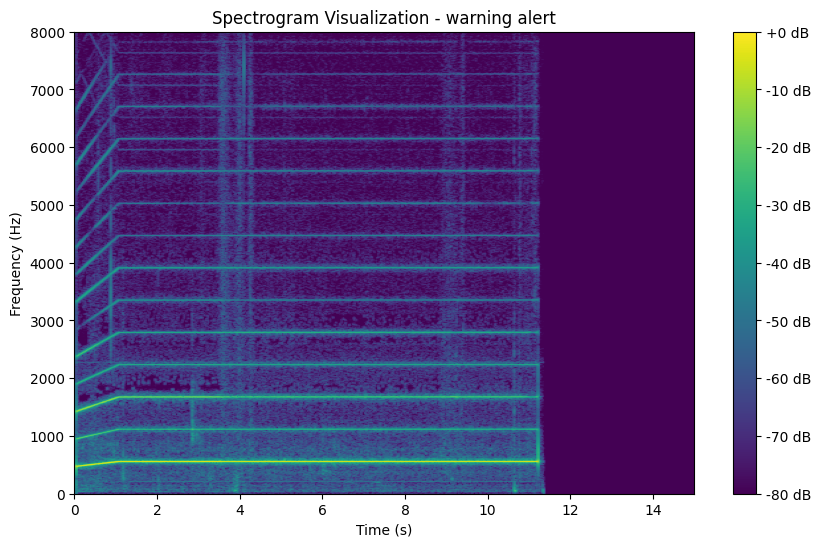

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로 설정
file_path = '/content/stft_data_fire/화재/경계경보.npy'

# 파라미터 설정 (참고: 오디오 전처리 시 사용한 값)
sample_rate = 16000  # 샘플링 레이트 (Hz)
hop_length = 512     # STFT hop length
duration = 15        # 오디오 길이 (초)

# 스펙트로그램 데이터 불러오기
stft_data = np.load(file_path)
print(f"Loaded Spectrogram Shape: {stft_data.shape}")

# Time 축 생성
num_frames = stft_data.shape[1]  # 스펙트로그램의 시간 프레임 수
time_axis = np.linspace(0, duration, num_frames)

# Frequency 축 생성
num_bins = stft_data.shape[0]  # 스펙트로그램의 주파수 축 길이
freq_axis = np.linspace(0, sample_rate // 2, num_bins)  # Nyquist 주파수까지

# 스펙트로그램 시각화
plt.figure(figsize=(10, 6))
plt.imshow(stft_data, aspect='auto', origin='lower', cmap='viridis',
           extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram Visualization - warning alert")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


Loaded Spectrogram Shape: (1025, 469)


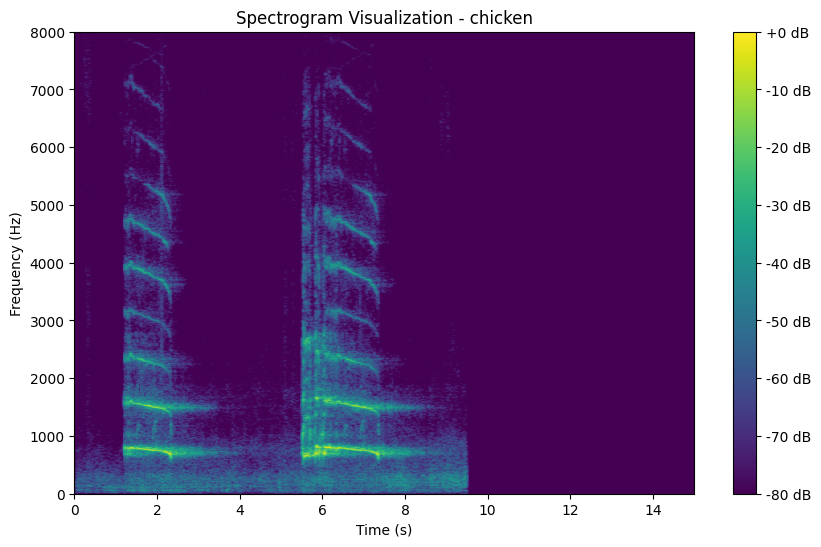

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로 설정
file_path = '/content/stft_data_fire/대피아닌 것/닭.npy'

# 파라미터 설정 (참고: 오디오 전처리 시 사용한 값)
sample_rate = 16000  # 샘플링 레이트 (Hz)
hop_length = 512     # STFT hop length
duration = 15        # 오디오 길이 (초)

# 스펙트로그램 데이터 불러오기
stft_data = np.load(file_path)
print(f"Loaded Spectrogram Shape: {stft_data.shape}")

# Time 축 생성
num_frames = stft_data.shape[1]  # 스펙트로그램의 시간 프레임 수
time_axis = np.linspace(0, duration, num_frames)

# Frequency 축 생성
num_bins = stft_data.shape[0]  # 스펙트로그램의 주파수 축 길이
freq_axis = np.linspace(0, sample_rate // 2, num_bins)  # Nyquist 주파수까지

# 스펙트로그램 시각화
plt.figure(figsize=(10, 6))
plt.imshow(stft_data, aspect='auto', origin='lower', cmap='viridis',
           extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram Visualization - chicken")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


Loaded Spectrogram Shape: (1025, 469)


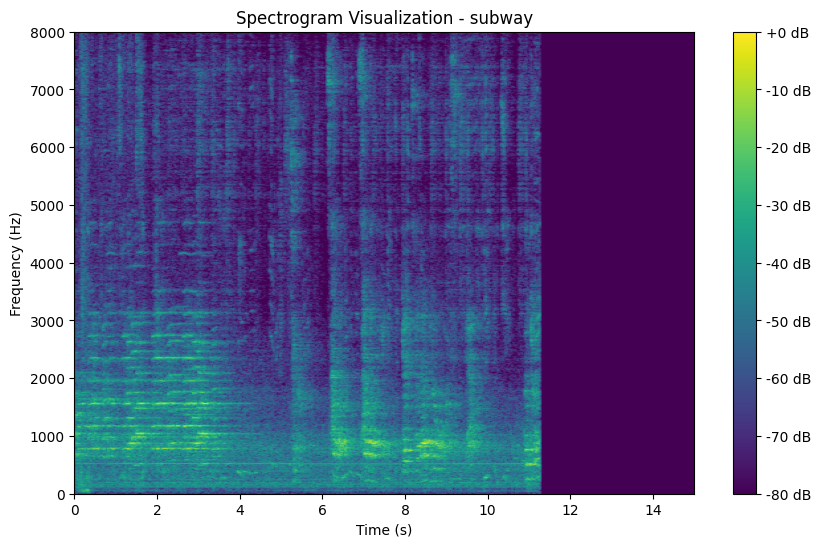

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로 설정
file_path = '/content/stft_data_fire/대피아닌 것/지하철 소리.npy'

# 파라미터 설정 (참고: 오디오 전처리 시 사용한 값)
sample_rate = 16000  # 샘플링 레이트 (Hz)
hop_length = 512     # STFT hop length
duration = 15        # 오디오 길이 (초)

# 스펙트로그램 데이터 불러오기
stft_data = np.load(file_path)
print(f"Loaded Spectrogram Shape: {stft_data.shape}")

# Time 축 생성
num_frames = stft_data.shape[1]  # 스펙트로그램의 시간 프레임 수
time_axis = np.linspace(0, duration, num_frames)

# Frequency 축 생성
num_bins = stft_data.shape[0]  # 스펙트로그램의 주파수 축 길이
freq_axis = np.linspace(0, sample_rate // 2, num_bins)  # Nyquist 주파수까지

# 스펙트로그램 시각화
plt.figure(figsize=(10, 6))
plt.imshow(stft_data, aspect='auto', origin='lower', cmap='viridis',
           extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram Visualization - subway")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
🔥 위급! 대피하세요!


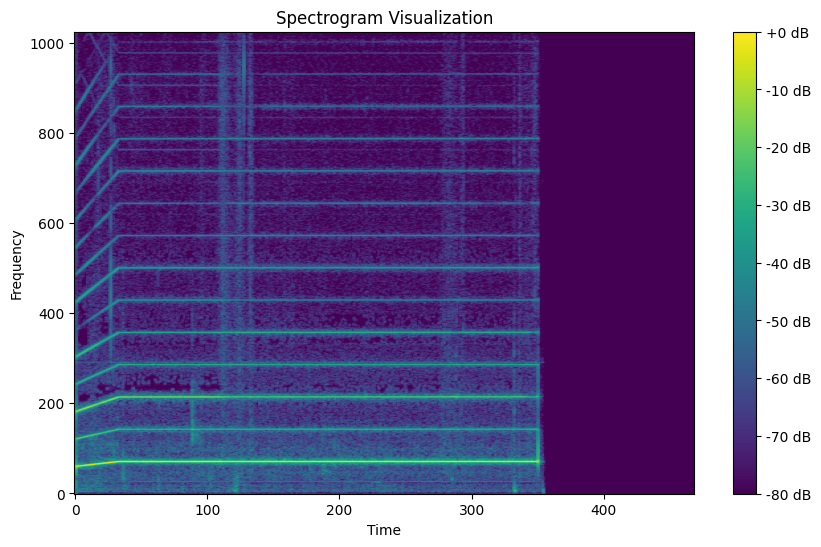

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


# 파일 경로 설정 (예측할 데이터)
file_path = '/content/stft_data_fire/화재/경계경보.npy'

# 스펙트로그램 데이터 불러오기
stft_data = np.load(file_path)

# 데이터 전처리: 모델 입력 형식에 맞게 변환
img_height, img_width = 128, 128  # 모델 학습 시 사용된 입력 크기
stft_data = np.expand_dims(stft_data, axis=-1)  # 채널 차원 추가 (Height, Width, 1)
input_data = tf.image.resize(stft_data, [img_height, img_width])  # 크기 변경
input_data = np.expand_dims(input_data, axis=0)  # 배치 차원 추가 (1, Height, Width, 1)

# 예측 수행
prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)  # 예측된 클래스 (0: 안전 소리, 1: 화재 소리)

# 결과 출력
if predicted_class == 0:
    print("🔥 위급! 대피하세요!")
else:
    print("✅ 안전 소리 감지. 문제가 없습니다.")

# 스펙트로그램 시각화 (선택)
plt.figure(figsize=(10, 6))
plt.imshow(stft_data.squeeze(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram Visualization")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


<Figure size 800x600 with 0 Axes>

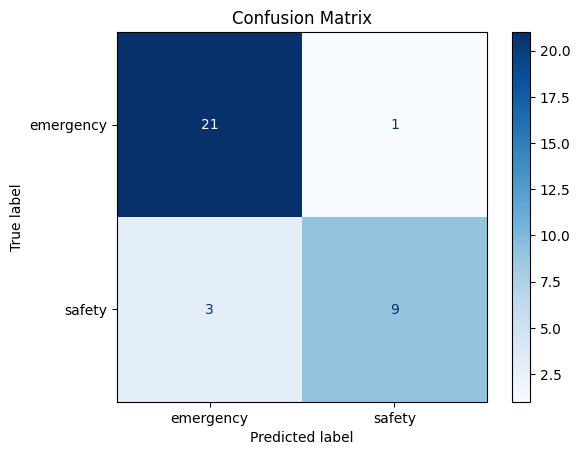

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 예측 수행
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 (0 또는 1)
y_true_classes = np.argmax(y_test, axis=1)  # 실제 클래스 (0 또는 1)

# Confusion Matrix 계산
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['emergency', 'safety'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()